In [1]:
import random
import os

import pickle 
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

# For dynamic bucketing
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
from torch.utils.data import Dataset,Sampler
from torch.utils.data import DataLoader

import torchaudio
from torchaudio.transforms import Spectrogram

from IPython.display import Audio, Markdown, display

In [2]:
# Check if GPU availability and set the device
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("No GPU available, using CPU")
    device = torch.device("cpu")

# Check if the device is set correctly
print(f"Device set to: {device}")

# Set the audio backend to soundfile (Uncomment if needed)
torchaudio.set_audio_backend("soundfile")

Using GPU: NVIDIA GeForce RTX 3060
Device set to: cuda


/tmp/ipykernel_657451/690487593.py:13: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


In [3]:
import torch
import torchaudio
import torchaudio.transforms as T
import os
import pickle

class SpeechDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir, set_type, rate, n_fft, hop_length):
        self.rate = rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.cache_file = os.path.join("cache/pto", f"{set_type}_lengths.pkl")

        clean_dir = os.path.join(dataset_dir, f"clean_{set_type}_wav")
        noisy_dir = os.path.join(dataset_dir, f"noisy_{set_type}_wav")

        self.clean_files = sorted([os.path.join(clean_dir, f) for f in os.listdir(clean_dir)], key=lambda x: os.path.basename(x))
        self.noisy_files = sorted([os.path.join(noisy_dir, f) for f in os.listdir(noisy_dir)], key=lambda x: os.path.basename(x))

        self.spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=None)

        # Store original lengths
        self.lengths = self.compute_lengths()

    def compute_lengths(self):
        """Compute and cache the original sequence lengths for each file."""
        if os.path.exists(self.cache_file):
            print(f"📂 Loading cached lengths from {self.cache_file}...")
            with open(self.cache_file, "rb") as f:
                return pickle.load(f)

        print("📏 Computing original sequence lengths...")
        lengths = [torchaudio.load(file)[0].shape[1] for file in self.clean_files]

        # Cache the lengths
        with open(self.cache_file, "wb") as f:
            pickle.dump(lengths, f)

        return lengths

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        """Return noisy, clean spectrograms + original length before padding."""
        noisy_waveform, n_sr = torchaudio.load(self.noisy_files[idx])
        clean_waveform, c_sr = torchaudio.load(self.clean_files[idx])
        orig_length = int(self.lengths[idx])

        # Convert stereo to mono
        noisy_waveform = noisy_waveform.mean(dim=0, keepdim=True) if noisy_waveform.shape[0] > 1 else noisy_waveform
        clean_waveform = clean_waveform.mean(dim=0, keepdim=True) if clean_waveform.shape[0] > 1 else clean_waveform

        # Resample if needed
        if n_sr != self.rate:
            noisy_waveform = T.Resample(n_sr, self.rate)(noisy_waveform)
        if c_sr != self.rate:
            clean_waveform = T.Resample(c_sr, self.rate)(clean_waveform)

        # Compute STFT (Complex Spectrogram)
        noisy_spec = self.spectrogram(noisy_waveform)
        clean_spec = self.spectrogram(clean_waveform)

        # Normalize
        noisy_spec = (noisy_spec - noisy_spec.mean()) / (noisy_spec.std() + 1e-6)
        clean_spec = (clean_spec - clean_spec.mean()) / (clean_spec.std() + 1e-6)

        # Separate into real & imaginary components
        return (
            noisy_spec.real, noisy_spec.imag,
            clean_spec.real, clean_spec.imag,
            orig_length
        )


In [4]:
def pto_collate_fn(batch):

    tn_real, tn_imag, tc_real, tc_imag, orig_lengths = zip(*batch)

    # 🚀 Step 1: Ensure a Fixed `F` Dimension
    target_F = max(x.shape[1] for x in tn_real)  # Find max `F`
    tn_real = [F.interpolate(x.unsqueeze(0), size=(target_F, x.shape[2]), mode="bilinear", align_corners=False).squeeze(0) for x in tn_real]
    tn_imag = [F.interpolate(x.unsqueeze(0), size=(target_F, x.shape[2]), mode="bilinear", align_corners=False).squeeze(0) for x in tn_imag]
    tc_real = [F.interpolate(x.unsqueeze(0), size=(target_F, x.shape[2]), mode="bilinear", align_corners=False).squeeze(0) for x in tc_real]
    tc_imag = [F.interpolate(x.unsqueeze(0), size=(target_F, x.shape[2]), mode="bilinear", align_corners=False).squeeze(0) for x in tc_imag]

    # 🚀 Step 2: Find Maximum `T` and Pad to It (Handles All Lengths Properly)
    max_T = max(x.shape[2] for x in tn_real)  # Find max `T`
    tn_real = [F.pad(x, (0, max_T - x.shape[2])) for x in tn_real]
    tn_imag = [F.pad(x, (0, max_T - x.shape[2])) for x in tn_imag]
    tc_real = [F.pad(x, (0, max_T - x.shape[2])) for x in tc_real]
    tc_imag = [F.pad(x, (0, max_T - x.shape[2])) for x in tc_imag]

    # Convert to stacked tensors
    tn_real = torch.stack(tn_real)
    tn_imag = torch.stack(tn_imag)
    tc_real = torch.stack(tc_real)
    tc_imag = torch.stack(tc_imag)

    # Convert `orig_lengths` to a tensor
    orig_lengths = torch.tensor(orig_lengths, dtype=torch.int64)

    return tn_real, tn_imag, tc_real, tc_imag, orig_lengths


In [5]:
# === Usage ===
dataset_dir = "../ED-Noisy-Speech-Datashare"
sr = 48000
n_fft = 1024
hop_length = 256

# === Initialize PTO/OT Datasets ===
train_dataset = SpeechDataset(dataset_dir, "trainset_56spk", sr, n_fft, hop_length)
val_dataset = SpeechDataset(dataset_dir, "trainset_28spk", sr, n_fft, hop_length)
test_dataset = SpeechDataset(dataset_dir, "testset", sr, n_fft, hop_length)

# === Create DataLoaders ===
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=pto_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=pto_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=pto_collate_fn)

📂 Loading cached lengths from cache/pto/trainset_56spk_lengths.pkl...
📂 Loading cached lengths from cache/pto/trainset_28spk_lengths.pkl...
📂 Loading cached lengths from cache/pto/testset_lengths.pkl...


In [6]:
def visualize_padding(dataset, title_prefix="Train"):

    # Extract original waveform lengths
    original_lengths = dataset.lengths  # Lengths are precomputed in SpeechDataset

    # Extract max padded length (simulate a batch)
    max_padded_length = max(original_lengths)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Histogram of Original Lengths
    axes[0].hist(original_lengths, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0].set_xlabel("Waveform Length (samples)")
    axes[0].set_ylabel("Count")
    axes[0].set_title(f"{title_prefix} Dataset: Original Waveform Length Distribution")
    axes[0].grid(True)

    # Show how all sequences are padded to max length
    axes[1].bar(["Original", "Padded"], [sum(original_lengths), len(original_lengths) * max_padded_length],
                color=['blue', 'orange'], alpha=0.7)
    axes[1].set_ylabel("Total Length (samples)")
    axes[1].set_title(f"{title_prefix} Dataset: Effect of Padding (PTO/OT)")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

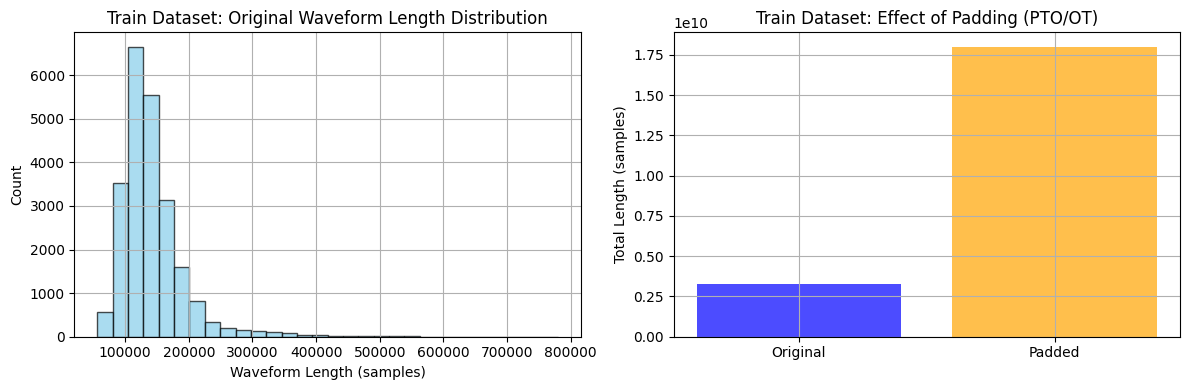

In [7]:
# Visualize the padding effect on the train
visualize_padding(train_dataset, "Train")

In [8]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train_eval(device, model, train_loader, val_loader, epochs, lr, save_pth):
    # Move model to device
    model.to(device)

    # Optimizer & Loss Function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Training and Validation variables
    best_val_loss = float('inf')  
    train_losses, val_losses = [], []  
    val_snrs = []  

    # Iterate over epochs
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0

        # Training Loop
        for tn_real, tn_imag, tc_real, tc_imag, orig_lengths in train_loader:  # ✅ Unpacking `orig_lengths`
            noisy_real, noisy_imag = tn_real.to(device), tn_imag.to(device)
            clean_real, clean_imag = tc_real.to(device), tc_imag.to(device)

            optimizer.zero_grad()
            outputs_real, outputs_imag = model(noisy_real, noisy_imag)

            # 🚀 Truncate outputs to match original lengths (Avoiding In-Place Modification)
            truncated_real = torch.stack([outputs_real[i, :, :, :orig_lengths[i].item()].clone() for i in range(outputs_real.shape[0])])
            truncated_imag = torch.stack([outputs_imag[i, :, :, :orig_lengths[i].item()].clone() for i in range(outputs_imag.shape[0])])
            clean_real = torch.stack([clean_real[i, :, :, :orig_lengths[i].item()].clone() for i in range(clean_real.shape[0])])
            clean_imag = torch.stack([clean_imag[i, :, :, :orig_lengths[i].item()].clone() for i in range(clean_imag.shape[0])])

            # Compute loss
            loss = criterion(truncated_real, clean_real) + criterion(truncated_imag, clean_imag)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation Loop
        model.eval()
        total_val_loss = 0.0
        snr_sum, snr_count = 0.0, 0  

        with torch.no_grad():
            for vn_real, vn_imag, vc_real, vc_imag, orig_lengths in val_loader:  # ✅ Include `orig_lengths`
                val_real, val_imag = vn_real.to(device), vn_imag.to(device)
                val_clean_real, val_clean_imag = vc_real.to(device), vc_imag.to(device)

                val_outputs_real, val_outputs_imag = model(val_real, val_imag)

                # 🚀 Truncate outputs to match original lengths (Avoiding In-Place Modification)
                val_truncated_real = torch.stack([val_outputs_real[i, :, :, :orig_lengths[i].item()].clone() for i in range(val_outputs_real.shape[0])])
                val_truncated_imag = torch.stack([val_outputs_imag[i, :, :, :orig_lengths[i].item()].clone() for i in range(val_outputs_imag.shape[0])])
                val_clean_real = torch.stack([val_clean_real[i, :, :, :orig_lengths[i].item()].clone() for i in range(val_clean_real.shape[0])])
                val_clean_imag = torch.stack([val_clean_imag[i, :, :, :orig_lengths[i].item()].clone() for i in range(val_clean_imag.shape[0])])

                val_loss = criterion(val_truncated_real, val_clean_real) + criterion(val_truncated_imag, val_clean_imag)
                total_val_loss += val_loss.item()

                # Compute Signal-to-Noise Ratio (SNR)
                snr_real = (val_clean_real.norm() / (val_truncated_real - val_clean_real).norm()).item()
                snr_imag = (val_clean_imag.norm() / (val_truncated_imag - val_clean_imag).norm()).item()
                avg_snr = (snr_real + snr_imag) / 2
                snr_sum += avg_snr
                snr_count += 1

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_snr = snr_sum / snr_count 
        val_losses.append(avg_val_loss)
        val_snrs.append(avg_val_snr)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val SNR: {avg_val_snr:.2f} dB")

        # Save the best model based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_pth)
            print(f"✔ Model saved to {save_pth} (Best Val Loss: {best_val_loss:.4f})")

    print("Training complete!")

    # Plot Loss & Accuracy Trends
    plt.figure(figsize=(12, 5))

    # Training & Validation Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, marker='o', color='b', label="Train Loss")
    plt.plot(range(1, epochs+1), val_losses, marker='s', color='r', label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.grid(True)
    plt.legend()

    # Validation SNR Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), val_snrs, marker='^', color='g', label="Val SNR (dB)")
    plt.xlabel("Epochs")
    plt.ylabel("SNR (dB)")
    plt.title("Validation SNR Over Epochs")
    plt.grid(True)
    plt.legend()

    plt.show()


In [9]:
class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()

        # Encoder (Downsampling)
        self.encoder = nn.Sequential(
            # Takes 2 channels (real + imag)
            nn.Conv2d(2, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        # Bottleneck layer 
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # Decoder (Upsampling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # Outputs 2 channels (real + imag)
            nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1), 
        )

    def forward(self, real, imag):
        # Foward pass through the network

        # Store original size for upsampling
        orig_size = real.shape[2:]

        # Stack real and imaginary as two-channel input
        x = torch.cat((real, imag), dim=1)

        # Pass through CNN
        x = self.encoder(x)
        # Bottle neck layer extracts the most important features
        x = self.bottleneck(x)
        x = self.decoder(x)

        # Ensure output size matches the original input
        x = F.interpolate(x, size=orig_size, mode="bilinear", align_corners=False)

        # Split the output back into real and imaginary components
        out_real, out_imag = torch.chunk(x, 2, dim=1)

        return out_real, out_imag

Epoch [1/10] - Loss: 0.4347, Val Loss: 0.4322, Val SNR: 1.41 dB
✔ Model saved to PadModels/PTO-OT.pth (Best Val Loss: 0.4322)


Epoch [2/10] - Loss: 0.4100, Val Loss: 0.4272, Val SNR: 1.46 dB
✔ Model saved to PadModels/PTO-OT.pth (Best Val Loss: 0.4272)


Epoch [3/10] - Loss: 0.4072, Val Loss: 0.4215, Val SNR: 1.48 dB
✔ Model saved to PadModels/PTO-OT.pth (Best Val Loss: 0.4215)


Epoch [4/10] - Loss: 0.4013, Val Loss: 0.4201, Val SNR: 1.43 dB
✔ Model saved to PadModels/PTO-OT.pth (Best Val Loss: 0.4201)


Epoch [5/10] - Loss: 0.3956, Val Loss: 0.4208, Val SNR: 1.47 dB


Epoch [6/10] - Loss: 0.3935, Val Loss: 0.4159, Val SNR: 1.43 dB
✔ Model saved to PadModels/PTO-OT.pth (Best Val Loss: 0.4159)


Epoch [7/10] - Loss: 0.3951, Val Loss: 0.4239, Val SNR: 1.49 dB


Epoch [8/10] - Loss: 0.3925, Val Loss: 0.4147, Val SNR: 1.49 dB
✔ Model saved to PadModels/PTO-OT.pth (Best Val Loss: 0.4147)


Epoch [9/10] - Loss: 0.3932, Val Loss: 0.4138, Val SNR: 1.47 dB
✔ Model saved to PadModels/PTO-OT.pth (Best Val Loss: 0.4138)


Epoch [10/10] - Loss: 0.3901, Val Loss: 0.4128, Val SNR: 1.45 dB
✔ Model saved to PadModels/PTO-OT.pth (Best Val Loss: 0.4128)
Training complete!


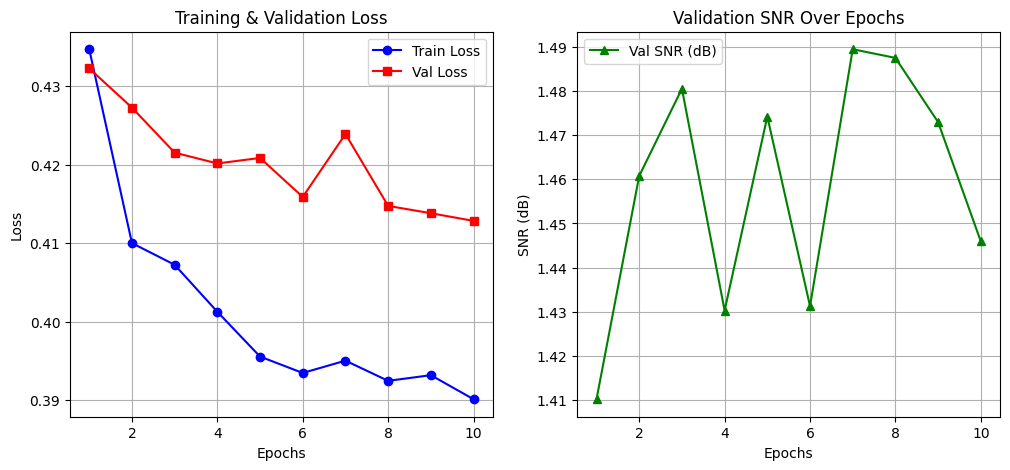

In [10]:
# Set the train and eval parameters
epochs = 10
lr = 1e-3
save_pth = "PadModels/PTO-OT.pth"

# Initialize the model
model = DenoisingCNN()

# Train the model
train_eval(device, model, train_loader, val_loader, epochs, lr, save_pth)

In [11]:
def denoise(device, model, model_pth, noisy_pth, output_pth, sr, nfft,  hop_length):
    # Ensure model and audio file exist
    if not os.path.exists(model_pth):
        raise FileNotFoundError(f"❌ Model file not found: {model_pth}")
    if not os.path.exists(noisy_pth):
        raise FileNotFoundError(f"❌ Noisy audio file not found: {noisy_pth}")

    # Load model weights
    model.load_state_dict(torch.load(model_pth, map_location=device))
    model.to(device)
    model.eval()

    # Define STFT & ISTFT transforms
    spectrogram = T.Spectrogram(n_fft=nfft, hop_length=hop_length, power=None).to(device)
    inverse_spectrogram = T.InverseSpectrogram(n_fft=nfft, hop_length=hop_length).to(device)

    # Load and preprocess the noisy audio
    noisy_signal, orig_sr = torchaudio.load(noisy_pth)

    # Convert stereo to mono if necessary
    if noisy_signal.shape[0] > 1:
        noisy_signal = noisy_signal.mean(dim=0, keepdim=True)

    # Resample if needed
    if orig_sr != sr:
        resample = T.Resample(orig_sr, sr).to(device)
        noisy_signal = resample(noisy_signal.to(device))

    # Compute complex spectrogram
    noisy_spec = spectrogram(noisy_signal.to(device))

    # Normalize spectrogram to prevent scaling issues
    noisy_spec = (noisy_spec - noisy_spec.mean()) / (noisy_spec.std() + 1e-6)

    # Separate real and imaginary components
    noisy_real, noisy_imag = noisy_spec.real, noisy_spec.imag

    # Process through the model
    with torch.no_grad():
        denoised_real, denoised_imag = model(noisy_real.unsqueeze(1), noisy_imag.unsqueeze(1))  # Add channel dim

    # Remove extra channel dimension
    denoised_real, denoised_imag = denoised_real.squeeze(1), denoised_imag.squeeze(1)

    # Reconstruct complex spectrogram
    denoised_spec = torch.complex(denoised_real, denoised_imag)

    # Convert back to waveform
    denoised_waveform = inverse_spectrogram(denoised_spec)

    # Prevent clipping issues
    denoised_waveform = torch.clamp(denoised_waveform, min=-1.0, max=1.0)

    # Save the denoised output
    torchaudio.save(output_pth, denoised_waveform.cpu(), sr)
    print(f"✅ Denoised audio saved to: {output_pth}")


In [12]:
def display_audio(noisy_pth, clean_pth, denoised_pth, sr):
    # Load audio files
    noisy_waveform, _ = torchaudio.load(noisy_pth)
    clean_waveform, _ = torchaudio.load(clean_pth)
    denoised_waveform, _ = torchaudio.load(denoised_pth)

    # Display audio comparisons
    display(Markdown("## 🎧 Audio Comparisons"))
    
    display(Markdown("### 🔊 Noisy Audio"))
    display(Audio(noisy_waveform.cpu().numpy(), rate=sr))
    
    display(Markdown("### 🎵 Clean Audio"))
    display(Audio(clean_waveform.cpu().numpy(), rate=sr))
    
    display(Markdown("### 🚀 Denoised Audio"))
    display(Audio(denoised_waveform.cpu().numpy(), rate=sr))


In [13]:
# Set the paths
model_pth = "PadModels/PTO-OT.pth"
noisy_pth = "../ED-Noisy-Speech-Datashare/noisy_testset_wav/p232_014.wav"
output_pth = "Output/PTO-OT_denioised.wav"
clean_pth = "../ED-Noisy-Speech-Datashare/clean_testset_wav/p232_014.wav"

# Perform the denoising
denoise(device, model, model_pth, noisy_pth, output_pth, sr, n_fft, hop_length)

✅ Denoised audio saved to: Output/PTO-OT_denioised.wav


In [14]:
# Display the audio
display_audio(noisy_pth, clean_pth, output_pth, sr)

## 🎧 Audio Comparisons

### 🔊 Noisy Audio

### 🎵 Clean Audio

### 🚀 Denoised Audio